In [1]:
import numpy as np
import pandas as pd
import pycountry as pyc
import os
import plotly
import telepyth
import datetime

import plotly.plotly as py
from plotly.graph_objs import Choropleth
from plotly.offline import init_notebook_mode, iplot
from IPython.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
init_notebook_mode(connected=True)

In [3]:
from sklearn import linear_model

In [4]:
start_date = datetime.datetime(2015, 3, 1)
end_date = datetime.datetime(2017, 12, 1)

n_months = (end_date - start_date).days * 12 // 365

dates = []
for i in range(n_months):
    index = start_date.month - 1 + i
    month = index % 12 + 1
    year = start_date.year + index // 12
    date = "{}_{:02d}".format(year, month)
    dates.append(date)

In [5]:
df = pd.read_csv(os.path.realpath('/Users/maximedelisle/Downloads/translingual_all_fully_cleaned_no_url.csv'), encoding='utf-8')

In [6]:
def select_events(df, feature, selector):
    '''Example of use : select_events(selected_df, 'EventCode', lambda x: x[:2] == '08')'''
    return df[df[feature].apply(selector)]

In [7]:
main_target = df['Target_CountryCode'].value_counts().index[:3]

In [8]:
dico = {}
for target in main_target:
    print('Target', target)
    df_main = select_events(df, 'Target_CountryCode', lambda x: x == target)
    df_main['Year_Month'] = df_main['Day'].apply(str).apply(lambda x: x[:4] + '_' + x[4:6])
    df_aggregated = pd.pivot_table(df_main, values='AvgTone', index=['Source_CountryCode'], columns=['Year_Month'])
    test_df = df_aggregated[dates].dropna(axis=0)
    for name, values in zip(test_df.index, test_df.values):
        x = list(range(len(values)))
        X = np.array([[a**i for a in x] for i in range(5)]).T
        y = values
        ransac_model = linear_model.Lasso()
        ransac_model.fit(X, y)
        weights = ransac_model.coef_
        if name in dico:
            dico[name] = np.append(dico[name], weights.reshape((1, 5)))
        else:
            dico[name] = weights.reshape((1, 5))

Target USA


/Users/maximedelisle/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/maximedelisle/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



Target RUS
Target UKR


In [9]:
from sklearn import cluster

In [10]:
clusters = cluster.AffinityPropagation()

In [11]:
X = []
label = []
for name, elem in zip(dico.keys(), dico.values()):
    if len(elem) > 14:
        X.append(elem)
        label.append(name)

In [12]:
clusters.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

In [13]:
X = np.array(X)

Estimated number of clusters: 12
Silhouette Coefficient: 0.465


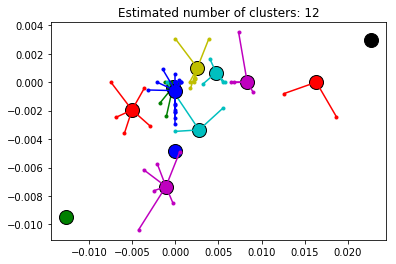

In [14]:
from sklearn import metrics

cluster_centers_indices = clusters.cluster_centers_indices_
labels = clusters.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()
a1 = 12
a2 = 2

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, a1], X[class_members, a2], col + '.')
    plt.plot(cluster_center[a1], cluster_center[a2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[a1], x[a1]], [cluster_center[a2], x[a2]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [25]:
def cca3_to_country(code):
    if code == 'UNK':
        return 'Kosovo'
    return pyc.countries.get(alpha_3=code).name

In [26]:
for i in range(12):
    print([cca3_to_country(code) for code in np.array(label)[labels == i]])

['Afghanistan']
['Belgium', 'Belarus', 'Switzerland', 'Colombia', 'Cyprus', 'France', 'United Kingdom', 'Korea, Republic of', 'Lebanon', 'Norway', 'United States']
['Bosnia and Herzegovina', 'China', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Turkey']
['Egypt', 'India', 'Jordan', 'Saudi Arabia']
['Bolivia, Plurinational State of', 'Brazil', 'Canada', 'Finland', 'Mexico', 'Slovenia']
['Albania', 'Argentina', 'Germany', 'Croatia', 'Hungary', 'Luxembourg', 'Poland', 'Uruguay', 'Venezuela, Bolivarian Republic of']
['Indonesia']
['Armenia', 'Austria', 'Azerbaijan', 'Bulgaria', 'Cuba', 'Czechia', 'Denmark', 'Algeria', 'Spain', 'Estonia', 'Greece', 'Israel', 'Italy', 'Lithuania', 'Latvia', 'Morocco', 'Moldova, Republic of', 'Palestine, State of', 'Russian Federation', 'Slovakia', 'Sweden', 'Tajikistan', 'Turkmenistan', 'Tuvalu', 'Ukraine']
['Montenegro']
['United Arab Emirates', 'Netherlands', 'Portugal']
['Chile', 'Iraq', 'Pakistan', 'Peru', 'Qatar']
['Micronesia, Federated States of', 'Iran, I